## N-gram 🥷🏻

In an n-gram language model, given a sequence of words $w$, we want to compute:

$$ P (w_i | w_{i-1}, w_{i-2}, ..., w_{i-n+1}) $$

where, $w_i$ is the ith word of the sequence.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserved thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)

len(test_sentence), test_sentence[:5]

(115, ['When', 'forty', 'winters', 'shall', 'besiege'])

---

### Let's create n_gram with context_size = 2

In [3]:

ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(f"{ngrams[:3]=}")

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

print(f"{len(vocab)=}")

ngrams[:3]=[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]
len(vocab)=97


---

## Create model

In [4]:

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) 
        # multiply by context_size (bcoz we'll be sending in context_size words at a time, so the input to the linear layer will be context_size * embedding_dim)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

/Users/Deependu/Library/Python/3.9/lib/python/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


---

## Train model

100%|██████████| 100/100 [00:01<00:00, 55.56it/s]


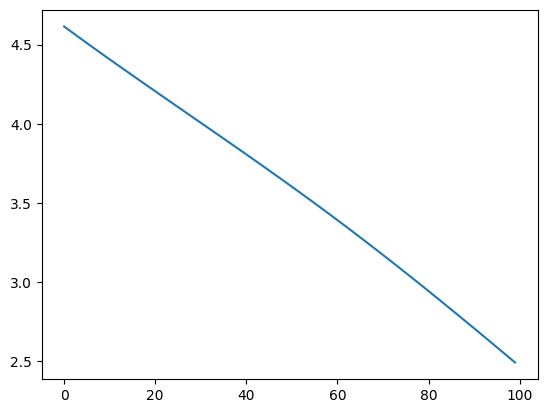

In [5]:
from tqdm import tqdm

no_of_epochs = 100

for epoch in tqdm(range(no_of_epochs)):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idx = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        optimizer.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idx)
        # print(f"{log_probs=}")
        # print(f"{word_to_ix[target]=}")

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

    avg_loss = total_loss / len(ngrams)
    losses.append(avg_loss)
    total_loss = 0

import matplotlib.pyplot as plt
plt.plot(losses, label="loss")

---

## Inspect embedding

In [6]:

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

tensor([-0.4559,  0.4691,  0.7495, -1.2047, -0.8022, -1.6192, -0.9212, -0.2266,
         1.0786, -1.6132], grad_fn=<SelectBackward0>)


In [7]:
print(model.embeddings.weight.size())

torch.Size([97, 10])


---

## Visualize the embeddings using **TensorBoard**

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("tensorboard/text-embedding-visualization")

writer.add_embedding(model.embeddings.weight, metadata=list(vocab))

#### Run the following command/cell to visualize the embeddings:

- visit `http://localhost:6006` in your web browser

```bash
tensorboard --logdir=tensorboard/text-embedding-visualization
```

In [11]:
!tensorboard --logdir=tensorboard/text-embedding-visualization

I0226 22:08:30.111429 6220034048 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
